<a href="https://colab.research.google.com/github/AhanR/NeuraHacks-forestFire/blob/main/forest_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detecting the area of the forest fire based on FWI system indices**


In [ ]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

forestFireData = pd.read_csv("forestfires.csv")

In [ ]:
display(forestFireData)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


Create a new dataframe without any extra data such as X,Y coords, date, temperature and rain levels(in this col the data was insufficient so we dropped it)

In [ ]:
fireAreaData = forestFireData
fireAreaData = fireAreaData.drop(fireAreaData.index[fireAreaData["area"] == 0])
del fireAreaData["X"], fireAreaData["Y"], fireAreaData["month"], fireAreaData["temp"], fireAreaData["rain"], fireAreaData["day"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plotDataVsArea(item) :
  y = fireAreaData["area"]
  # y = np.log(fireAreaData["area"])
  plt.scatter(fireAreaData[item], y)
  plt.title(f"{item} vs Area")
  plt.xlabel(item)
  plt.ylabel("Area")
  plt.show()

#basic data cleaning

In [ ]:
fireAreaData = fireAreaData.drop(fireAreaData.index[fireAreaData["area"] > 100])

#Visualising the data

In [ ]:
fireAreaData.corr()

,FFMC,DMC,DC,ISI,RH,wind,area
FFMC,1.000000,0.480250,0.407638,0.704170,-0.285990,-0.161384,0.054323
DMC,0.480250,1.000000,0.668926,0.329656,0.027861,-0.137897,0.089088
DC,0.407638,0.668926,1.000000,0.256826,-0.082217,-0.237593,0.046735
ISI,0.704170,0.329656,0.256826,1.000000,-0.148804,0.072652,0.002121
RH,-0.285990,0.027861,-0.082217,-0.148804,1.000000,0.138490,-0.104846
wind,-0.161384,-0.137897,-0.237593,0.072652,0.138490,1.000000,0.002086
area,0.054323,0.089088,0.046735,0.002121,-0.104846,0.002086,1.000000


In [ ]:
import seaborn as sns
sns.pairplot(fireAreaData)

Normalising the input and output values for better training results

In [ ]:
x = fireAreaData.drop('area', axis = 1)
y = fireAreaData["area"]
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = 0.15,random_state = 24, shuffle = True)

In [ ]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#**Different models**

#Neural net

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = [x_train.shape[1]]

model =  keras.Sequential([
    layers.Dense(64, activation = 'relu', input_shape=input_shape),
    layers.Dense(32, activation = 'relu', name="layer_2"),
    layers.Dense(16, activation = 'relu', name="layer_3"),
    layers.Dense(1, activation = 'sigmoid', name="layer_out")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 layer_2 (Dense)             (None, 16)                528       
                                                                 
 layer_out (Dense)           (None, 1)                 17        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="mae",metrics=['accuracy'])

In [ ]:
losses = model.fit(x_train_scaled, y_train,
                   validation_data=(x_test_scaled, y_test),
                   batch_size=16,
                   epochs=8)

Epoch 1/8
15/15 [==============================] - 4s 24ms/step - loss: 25.4545 - accuracy: 0.0000e+00 - val_loss: 16.0038 - val_accuracy: 0.0000e+00
Epoch 2/8
15/15 [==============================] - 0s 7ms/step - loss: 25.3222 - accuracy: 0.0000e+00 - val_loss: 15.8587 - val_accuracy: 0.0000e+00
Epoch 3/8
15/15 [==============================] - 0s 7ms/step - loss: 25.2011 - accuracy: 0.0000e+00 - val_loss: 15.7692 - val_accuracy: 0.0000e+00
Epoch 4/8
15/15 [==============================] - 0s 7ms/step - loss: 25.1393 - accuracy: 0.0000e+00 - val_loss: 15.7399 - val_accuracy: 0.0000e+00
Epoch 5/8
15/15 [==============================] - 0s 7ms/step - loss: 25.1203 - accuracy: 0.0000e+00 - val_loss: 15.7319 - val_accuracy: 0.0000e+00
Epoch 6/8
15/15 [==============================] - 0s 8ms/step - loss: 25.1153 - accuracy: 0.0000e+00 - val_loss: 15.7289 - val_accuracy: 0.0000e+00
Epoch 7/8
15/15 [==============================] - 0s 7ms/step - loss: 25.1134 - accuracy: 0.0000e+00 - v

In [ ]:
model.predict(x_test_scaled)

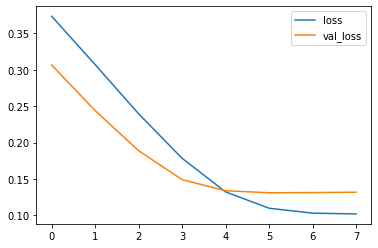

In [ ]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()

#Linear regression

In [ ]:
model2 = LinearRegression()
model2.fit(x_train_scaled,y_train)

LinearRegression()

In [ ]:
y_pred=model2.predict(x_test_scaled)
y_test=y_test.to_numpy()
plt.scatter(y_test,y_pred)

In [ ]:
model2.score(x_test_scaled,y_test)

-0.10555445893723703

#Decision tree regressor

In [ ]:
model3 = DecisionTreeRegressor()
model3.fit(x_train_scaled,y_train)

DecisionTreeRegressor()

In [ ]:
model3.score(x_test_scaled,y_test)

-1.4353057316765838

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)
print("testing accuracy has reached : " , score)

testing accuracy has reached :  [0.1319705694913864, 0.0]


#Extra code

In [ ]:
parameters = ["FFMC", "wind", "RH", "DMC", "DC", "ISI"]
for param in parameters :
  plotDataVsArea(param)

In [ ]:
high = fireAreaData.max(axis = 0)
low = fireAreaData.min(axis = 0)
#fireAreaData["area"] = ((fireAreaData["area"]) - low["area"])/high["area"]
fireAreaData["FFMC"] = ((fireAreaData["FFMC"]) - 18.70)/77.5
fireAreaData["wind"] = ((fireAreaData["wind"]) - 0.40)/9
fireAreaData["RH"] = ((fireAreaData["RH"]) - 15)/85
fireAreaData["DMC"] = ((fireAreaData["DMC"]) - 1.1)/290.2
fireAreaData["DC"] = ((fireAreaData["DC"]) - 7.9)/852.7
fireAreaData["ISI"] = (fireAreaData["ISI"])/56.1